In [106]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [124]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

In [130]:
# dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    shuffle_files=True,
    with_info=True,
    as_supervised = True
)

In [128]:
ds_info.features['label'].num_classes

2

In [129]:
ds_info.features['label'].names

['cat', 'dog']

In [126]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(normalize_and_resize_img, num_parallel_calls=1)
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [131]:
BATCH_SIZE = 32

ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [116]:
def build_resnet_block(input_layer, num_cnn=3, channel=64, block_num=1,is_50 = False, is_plain = False):
    # 입력 레이어
    x = input_layer
    if not is_50: # ResNet-34
    # CNN 레이어
        for cnn_num in range(num_cnn):
            x_skip = x
            
            x_skip_channel = x_skip.shape.as_list()[-1] 
            
            # 1번째 layer 부분
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides = (2 if x_skip_channel != channel else 1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            
            # 2번째 layer 부분
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=1,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            
            if not is_plain:
                x_skip_channel = x_skip.shape.as_list()[-1]    

                if x_skip_channel != channel:
                    x_skip = keras.layers.Conv2D(channel, kernel_size=(1, 1), strides=(2, 2), padding="same")(x_skip)  
                    x_skip = keras.layers.BatchNormalization()(x_skip)
                # skip connection
                x = keras.layers.Add()([x,x_skip])
                x = keras.layers.ReLU()(x)
            else:
                x = keras.layers.ReLU()(x)
                
    if is_50: # ResNet-50
    # CNN 레이어
        a_1 = 3
        for cnn_num in range(num_cnn):
            x_skip = x

            if block_num == 3 and cnn_num == 0:
                a_1 = 6
            
            if cnn_num == 0 and block_num == 0:
                x_skip = keras.layers.Conv2D(
                            filters=channel * 4,
                            kernel_size=(1,1),
                            strides=1,
                            name=f'0_block{block_num}_conv{cnn_num}'
                )(x_skip)
                x_skip = keras.layers.BatchNormalization()(x_skip)

            # 첫번째 layer 부분
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(1,1),
                strides=(2 if block_num != 0 and cnn_num == 0 else 1),
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            
            # 두번째 layer 부분
            x = keras.layers.Conv2D(
                filters=channel,
                kernel_size=(3,3),
                strides=1,
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_1_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)
            x = keras.layers.ReLU()(x)
            
            # 세번째 layer 부분
            x = keras.layers.Conv2D(
                filters=channel * 4,
                kernel_size=(1,1),
                strides=1,
                activation='relu',
                kernel_initializer='he_normal',
                padding='same',
                name=f'block{block_num}_2_conv{cnn_num}'
            )(x)
            x = keras.layers.BatchNormalization()(x)

            if not is_plain:
                if a_1 != num_cnn:
                    x_skip = keras.layers.Conv2D(channel*4, kernel_size=(1, 1), strides=(2, 2), padding="same")(x_skip)  
                    x_skip = keras.layers.BatchNormalization()(x_skip)
                    a_1 = num_cnn
                    
                x = keras.layers.Add()([x,x_skip])   
                x = keras.layers.ReLU()(x)

            else:
                x = keras.layers.ReLU()(x)

    return x

In [117]:
def build_resnet(input_shape=(32,32,3),
              num_cnn_list=[3,4,6,3],
              channel_list=[64,128,256,512],
              num_classes=10,is_50 = False, is_plain = False, block_num=0):
    
    assert len(num_cnn_list) == len(channel_list) #모델을 만들기 전에 config list들이 같은 길이인지 확인합니다.
    if is_50:
        num_cnn_list = [3,4,6,3]
        channel_list = [64,128,256,512]
        num_classes = 2
        
    input_layer = keras.layers.Input(shape=input_shape)  # input layer를 만들어둡니다.
    output = input_layer
    #conv1층
    output = keras.layers.Conv2D(filters=64,
                       kernel_size = (7,7),
                       strides = 2,
                         padding = 'same')(output)
    output = keras.layers.BatchNormalization()(output)
    output = keras.layers.ReLU()(output)
    
    #conv2_x pooling
    output = keras.layers.MaxPooling2D(pool_size = (3,3),
                                      strides = 2, padding='same')(output)    
    # config list들의 길이만큼 반복해서 블록을 생성합니다.
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_block(
            output,
            num_cnn=num_cnn, 
            channel=channel,
            block_num=i,
            is_plain=is_plain,
            is_50=is_50
        )    
    output = keras.layers.GlobalAveragePooling2D()(output)
    output = keras.layers.Flatten(name='flatten')(output)   
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(
        inputs=input_layer, 
        outputs=output
    )
    return model

## ResNet-34 및 Plain_ResNet-34 구현

In [ ]:
resnet34 = build_resnet(input_shape=(224,224,3), num_classes=2)
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 112, 112, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 112, 112, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
plain_resnet34 = build_resnet(is_50=False, is_plain=True, input_shape=(224,224,3), num_classes=2)
plain_resnet34.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_36 (Bat  (None, 112, 112, 64)     256       
 chNormalization)                                                
                                                                 
 re_lu_33 (ReLU)             (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 block0_conv0 (Conv2D)       (None, 56, 56, 64)        3692

In [ ]:
BATCH_SIZE = 32
EPOCH = 30
# cats_vs_dogs dataset load
(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [ ]:
# ResNet34 Plain
plain_resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_plain = plain_resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 143s 196ms/step - loss: 0.6908 - accuracy: 0.5472 - val_loss: 1.8007 - val_accuracy: 0.5152
Epoch 2/30
581/581 [==============================] - 113s 194ms/step - loss: 0.6876 - accuracy: 0.5571 - val_loss: 0.7384 - val_accuracy: 0.5087
Epoch 3/30
581/581 [==============================] - 114s 197ms/step - loss: 0.6832 - accuracy: 0.5656 - val_loss: 0.7322 - val_accuracy: 0.5396
Epoch 4/30
581/581 [==============================] - 115s 198ms/step - loss: 0.6776 - accuracy: 0.5765 - val_loss: 1.2963 - val_accuracy: 0.5128
Epoch 5/30
581/581 [==============================] - 115s 198ms/step - loss: 0.6541 - accuracy: 0.6152 - val_loss: 0.8388 - val_accuracy: 0.5624
Epoch 6/30
581/581 [==============================] - 115s 198ms/step - loss: 0.6467 - accuracy: 0.6303 - val_loss: 0.6721 - val_accuracy: 0.5928
Epoch 7/30
581/581 [==============================] - 115s 198ms/step - loss: 0.6426 - accuracy: 0.6362 - val_loss: 0.6650 -

In [ ]:
# ResNet34 Residual
resnet34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_34_residual = resnet34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test, 
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 136s 210ms/step - loss: 0.6539 - accuracy: 0.6203 - val_loss: 0.6309 - val_accuracy: 0.6401
Epoch 2/30
581/581 [==============================] - 121s 209ms/step - loss: 0.5998 - accuracy: 0.6753 - val_loss: 1.0838 - val_accuracy: 0.5662
Epoch 3/30
581/581 [==============================] - 121s 209ms/step - loss: 0.5594 - accuracy: 0.7098 - val_loss: 1.0118 - val_accuracy: 0.5396
Epoch 4/30
581/581 [==============================] - 121s 209ms/step - loss: 0.5120 - accuracy: 0.7460 - val_loss: 0.5949 - val_accuracy: 0.6931
Epoch 5/30
581/581 [==============================] - 121s 209ms/step - loss: 0.4660 - accuracy: 0.7775 - val_loss: 0.6157 - val_accuracy: 0.6862
Epoch 6/30
581/581 [==============================] - 121s 208ms/step - loss: 0.4208 - accuracy: 0.8074 - val_loss: 0.6911 - val_accuracy: 0.6764
Epoch 7/30
581/581 [==============================] - 121s 209ms/step - loss: 0.3695 - accuracy: 0.8344 - val_loss: 0.5372 -

## ResNet-34 및 Plain 시각화

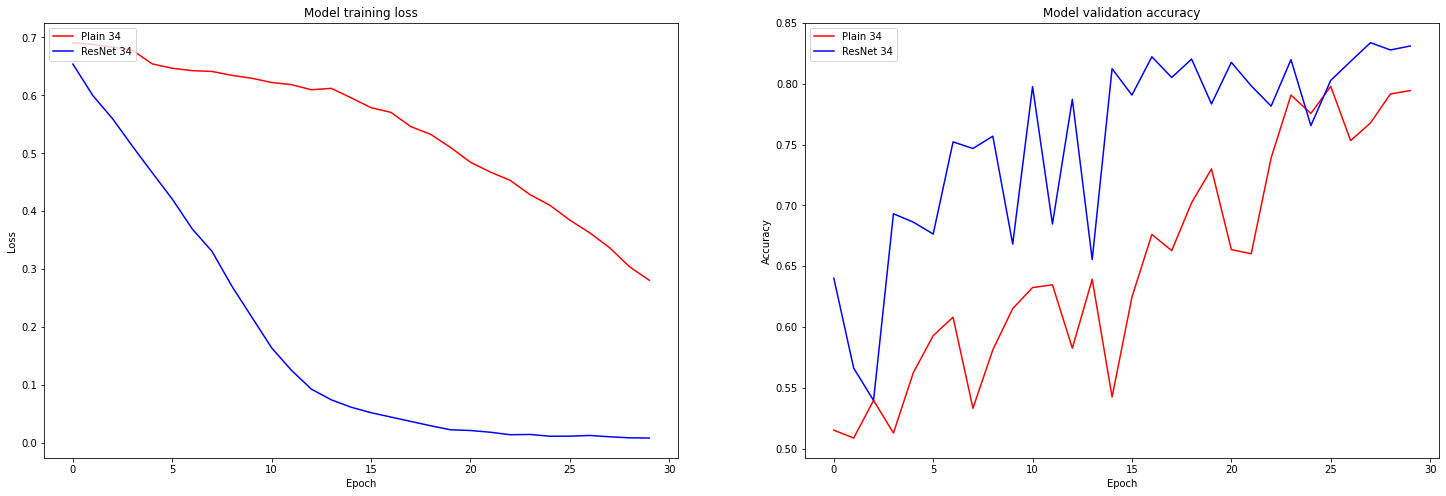

In [ ]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history_34_plain.history['loss'], 'r')
plt.plot(history_34_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain 34', 'ResNet 34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_34_plain.history['val_accuracy'], 'r')
plt.plot(history_34_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain 34', 'ResNet 34'], loc='upper left')
plt.show()

## ResNet-50 및 Plain_ResNet-50 구현

In [118]:
resnet50 = build_resnet(input_shape=(224,224,3), num_classes=2, is_50=True)
resnet50.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_32 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_82 (Conv2D)             (None, 112, 112, 64  9472        ['input_32[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_1146 (Batc  (None, 112, 112, 64  256        ['conv2d_82[0][0]']              
 hNormalization)                )                                                           

In [119]:
plain_resnet50 = build_resnet(input_shape=(224,224,3), num_classes=2, is_50=True, is_plain=True)
plain_resnet50.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_33 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_86 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_1199 (B  (None, 112, 112, 64)     256       
 atchNormalization)                                              
                                                                 
 re_lu_1098 (ReLU)           (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 56, 56, 64)       0         
 g2D)                                                            
                                                                 
 block0_conv0 (Conv2D)       (None, 56, 56, 64)        4160

In [132]:
# BATCH_SIZE = 32
EPOCH = 30

# ResNet50 Plain
plain_resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_plain = plain_resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/30
581/581 [==============================] - 216s 321ms/step - loss: 0.7023 - accuracy: 0.5427 - val_loss: 0.7485 - val_accuracy: 0.4938
Epoch 2/30
581/581 [==============================] - 183s 315ms/step - loss: 0.7005 - accuracy: 0.5427 - val_loss: 1.2103 - val_accuracy: 0.4933
Epoch 3/30
581/581 [==============================] - 183s 315ms/step - loss: 0.7026 - accuracy: 0.5332 - val_loss: 0.7064 - val_accuracy: 0.5269
Epoch 4/30
581/581 [==============================] - 183s 316ms/step - loss: 0.7000 - accuracy: 0.5314 - val_loss: 0.8160 - val_accuracy: 0.5439
Epoch 5/30
581/581 [==============================] - 183s 314ms/step - loss: 0.7011 - accuracy: 0.5350 - val_loss: 0.7079 - val_accuracy: 0.5080
Epoch 6/30
581/581 [==============================] - 183s 315ms/step - loss: 0.7022 - accuracy: 0.5227 - val_loss: 0.7221 - val_accuracy: 0.5030
Epoch 7/30
581/581 [==============================] - 183s 315ms/step - loss: 0.7046 - accuracy: 0.5189 - val_loss: 1.0877 -

In [133]:
# ResNet50 Residual
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_50_residual = resnet50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)


Epoch 1/30
581/581 [==============================] - 243s 373ms/step - loss: 0.7411 - accuracy: 0.5423 - val_loss: 0.7326 - val_accuracy: 0.5130
Epoch 2/30
581/581 [==============================] - 217s 374ms/step - loss: 0.7235 - accuracy: 0.5641 - val_loss: 0.8732 - val_accuracy: 0.5468
Epoch 3/30
581/581 [==============================] - 217s 374ms/step - loss: 0.7226 - accuracy: 0.5630 - val_loss: 1.3340 - val_accuracy: 0.5244
Epoch 4/30
581/581 [==============================] - 218s 375ms/step - loss: 0.7129 - accuracy: 0.5651 - val_loss: 0.7467 - val_accuracy: 0.5379
Epoch 5/30
581/581 [==============================] - 217s 374ms/step - loss: 0.7122 - accuracy: 0.5703 - val_loss: 0.7584 - val_accuracy: 0.5416
Epoch 6/30
581/581 [==============================] - 218s 375ms/step - loss: 0.7017 - accuracy: 0.5787 - val_loss: 0.8659 - val_accuracy: 0.5489
Epoch 7/30
581/581 [==============================] - 217s 374ms/step - loss: 0.7033 - accuracy: 0.5809 - val_loss: 1.0366 -

## ResNet-50 및 Plain 시각화

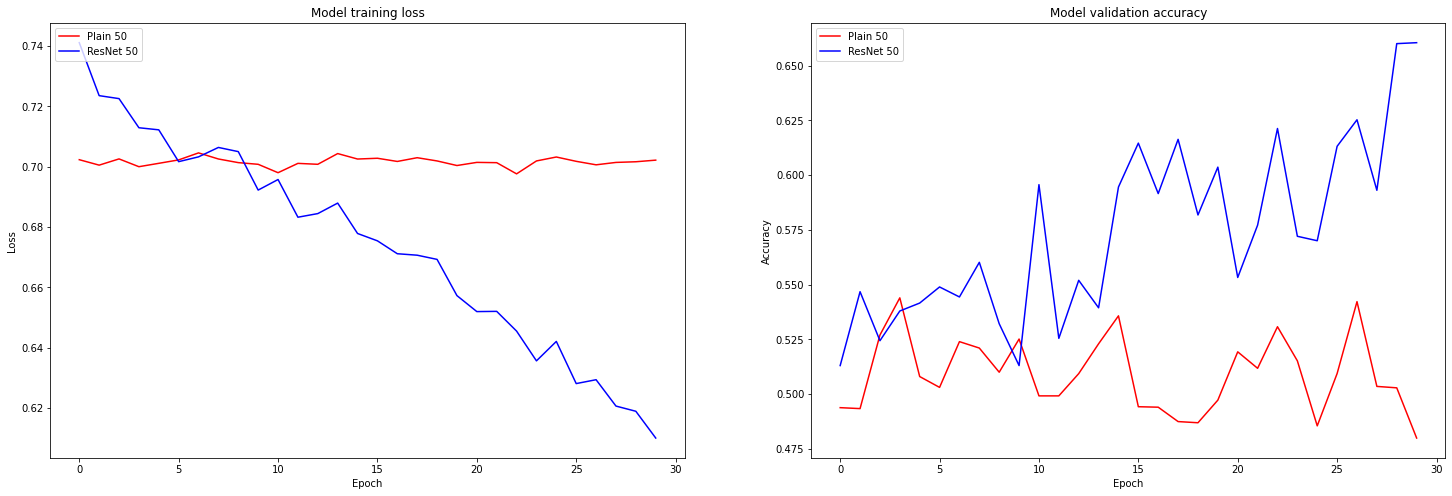

In [134]:
# 시각화
import matplotlib.pyplot as plt
figure = plt.figure(figsize=(25, 8))

plt.subplot(1, 2, 1)
plt.plot(history_50_plain.history['loss'], 'r')
plt.plot(history_50_residual.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Plain 50', 'ResNet 50'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_50_plain.history['val_accuracy'], 'r')
plt.plot(history_50_residual.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Plain 50', 'ResNet 50'], loc='upper left')
plt.show()

## 회고 
논문을 읽고 그것을 토대로 모든 것을 구현해보고 싶었지만 역량이 부족함을 느끼고 구글에 올라와있는 다양한 코드을 이해하고 이를 토대로 스스로 코딩을 했고 plain_ResNet-34, ResNet-34, plain_ResNet-50, ResNet-50을 구현해보았다. 논문을 보고 이해하고 구현한 것이 처음이라 코드가 효율적이지 못하지만 그래도 이렇게라도 부딪히며 결국 성공해내는게 앞으로 도움이 많이 될 것이라는 믿음이라 생각하고 했는데 결국 성공을 거둬서 뜻깊은 GoingDeeper라고 생각한다.  

결론을 말하자면 ResNet-34에서는 epoch를 수행하면서 크게 변화하는 모습을 볼 수 있었다. 하지만 overfitting의 모습이라고 판단되었다. 반면에 ResNet-50에서는 epoch가 수행되면서 상대적으로 미비했지만 overfitting 없이 accuracy는 성장했고 loss 값은 지속적으로 하락하는 모습을 볼 수 있었다.

이를 보면서 plain과 비교했을 때 확실히 ResNet이 효과적이라는 모습을 볼 수 있었고 skip connection이 모델에 들어오면서 다양한 약점들을 보완할 수 있다는 모습을 볼 수 있었다.

개인적인 생각을 기준으로 만든 모델이라 너무 힘들게 맞췄기에 다양한 파라미터를 수정해보고 싶었고 epoch를 늘려보고 싶었지만 Aiffel 특성상 해야할 것이 너무 많고 시간이 부족했기 때문에 모델을 구현해보고 결과를 확인해보는 것을 중점으로 보고 끝내는 것이 최선이라고 판단했다.  

하지만 이를 통해 논문 구현 등 다양한 경험을 쌓았다는 점이 큰 도움이 되었고 앞으로 논문을 읽고 구현해보는 역량을 키우는 능력을 쌓아야겠다고 생각했다.